# Examining gender bias in word embeddings for Russian language


In [1]:
import gensim
import scipy
import statistics
import numpy as np
from numpy import mean
import random
import urllib.request
import pandas as pd
import zipfile
import wget
import csv

## Loading Word Embeddings

from the site https://rusvectores.org/ru/models/


### Word embeddings used for the analysis:

**Word2vec models with Universal dependecies tags**:


1) ruscorpora_upos_cbow_300_20_2019 (http://vectors.nlpl.eu/repository/20/180.zip)

2) ruwikiruscorpora_upos_skipgram_300_2_2019 (http://vectors.nlpl.eu/repository/20/182.zip)

3) tayga_upos_skipgram_300_2_2019 (http://vectors.nlpl.eu/repository/20/185.zip)

4) news_upos_skipgram_300_5_2019 (http://vectors.nlpl.eu/repository/20/184.zip)

**Fasttext model without tags**

1) geowac_lemmas_none_fasttextskipgram_300_5_2020 (http://vectors.nlpl.eu/repository/20/213.zip)

In [ ]:
we_models = {#"geowac_lemmas_none_fasttextskipgram_300_5_2020": "http://vectors.nlpl.eu/repository/20/213.zip"}
             #"ruscorpora_upos_cbow_300_20_2019" : "http://vectors.nlpl.eu/repository/20/180.zip",
             #"ruwikiruscorpora_upos_skipgram_300_2_2019": "http://vectors.nlpl.eu/repository/20/182.zip"}
            # "tayga_upos_skipgram_300_2_2019":"http://vectors.nlpl.eu/repository/20/185.zip"
            # "araneum_lemmas_elmo_2048_2020":"http://vectors.nlpl.eu/repository/20/212.zip", #not downloaded
            # "Russian_CoNLL17_corpus":"http://vectors.nlpl.eu/repository/20/65.zip",
               "ruscorpora_none_fasttextskipgram_300_2_2019" :"http://vectors.nlpl.eu/repository/20/181.zip"}
               #"news_upos_skipgram_300_5_2019":"http://vectors.nlpl.eu/repository/20/184.zip"}

### Download the models into the folder "we_models"

In [ ]:
import sys

#create this bar_progress method which is invoked automatically from wget
def bar_progress(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
  # Don't use print() as it will print in new line every time
    sys.stdout.write("\r" + progress_message)
    sys.stdout.flush()

#saving all the model in the folder "we_models"
def get_models(model_url, model_name, path_to_save="./we_models/"):
    model_path = path_to_save + model_name + ".zip"
    m = wget.download(model_url, model_path, bar=bar_progress)
    model_file = model_url.split('/')[-1]
    
    with zipfile.ZipFile("./we_models/" + model_file, 'r') as archive:
        stream = archive.open('model.model')
        model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)
    

In [ ]:
for model_name, model_url in we_models.items():
    get_models(model_url, model_name)

### Open the model from an archieve or folder

In [2]:
#function for opening the we model from archieve (for word2vec models) or folder (for fasttext models)
def open_model(model_name,model_path, is_fasttext = False):
    if is_fasttext == False:
        model_file = model_path + model_name + ".zip"
        with zipfile.ZipFile(model_file, 'r') as archive:
            stream = archive.open('model.bin')
            model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)
    else:
        model_file = model_path + model_name
        model = gensim.models.KeyedVectors.load(model_file + "/model.model")
    return model

In [3]:
# Alternative way to open a model
#model = gensim.models.KeyedVectors.load_word2vec_format('we_models/navec_news_v1_1B_250K_300d_100q/vocab.bin', binary=False)

#OR

model = open_model("ruwikiruscorpora_upos_skipgram_300_2_2019", "./we_models/", is_fasttext = False)

### Assign male, female attributes and target terms

In [4]:
male_terms = ["мужчина_NOUN", "мужской_ADJ", "мальчик_NOUN", "брат_NOUN", "сын_NOUN", "отец_NOUN", "папа_NOUN", "дедушка_NOUN", "дядя_NOUN",
              "парень_NOUN", "господин_NOUN", "друг_NOUN", "племянник_NOUN", "барин_NOUN"]

female_terms = ["женщина_NOUN", "женский_ADJ", "девочка_NOUN", "сестра_NOUN", "дочь_NOUN", "мать_NOUN", "мама_NOUN", "бабушка_NOUN", "тетя_NOUN", 
                'девушка_NOUN', "госпожа_NOUN", "подруга_NOUN", "племянница_NOUN", "барышня_NOUN"]

In [5]:
targ_weat_files = ["career_family.txt",
             'science_arts.txt',
             'intelligence_appearence.txt',
             'strong_weak.txt',
             'tech_human.txt',
             'rational_emotional.txt']

### Test model vectors similarity

In [ ]:
model.similarity("парень_NOUN", "девочка_NOUN")

In [150]:
male_word_sets = []
female_word_sets = []
only_terms = []


for attr_weat_f in targ_weat_files:
    file_path = "./word_sets/{}".format(attr_weat_f)
    attr_weat = pd.read_csv(file_path)
    attr1, attr2 = list(attr_weat.iloc[:,0]), list(attr_weat.iloc[:,1])
    attr1_name, attr2_name = attr_weat.columns[0], attr_weat.columns[1]
    
    ### we append all attribute words to Only_terms list for the following PCA analysis 
    al = attr1 + attr2
    only_terms.extend(al)
    
    for male in male_terms:
        for word1 in attr1:
            if word1 in model:
                male_words1 = attr1_name, word1, male, model.similarity(word1, male)
                    
        for word2 in attr2:
            try:
                if word2 in model:
                    male_words2 = attr2_name, word2, male, model.similarity(word2, male)
                    male_word_sets.append(male_words1+male_words2)
            except TypeError:
                pass     
                 
    for female in female_terms:
        for word1 in attr1:
            if word1 in model:
                female_words1 = attr1_name, word1, female, model.similarity(word1, female)
                    
        for word2 in attr2:
            try:
                if word2 in model:
                    female_words2 = attr2_name, word2, female, model.similarity(word2, female)
                    #print(female_words2)
                    female_word_sets.append(female_words1+female_words2)
        
            except TypeError:
                pass      

('family', 'сын_NOUN', 'женщина_NOUN', 0.3092714)
('family', 'дочь_NOUN', 'женщина_NOUN', 0.44595116)
('family', 'дом_NOUN', 'женщина_NOUN', 0.20741424)
('family', 'родитель_NOUN', 'женщина_NOUN', 0.33506405)
('family', 'ребенок_NOUN', 'женщина_NOUN', 0.53031325)
('family', 'семья_NOUN', 'женщина_NOUN', 0.275014)
('family', 'родня_NOUN', 'женщина_NOUN', 0.22173285)
('family', 'брак_NOUN', 'женщина_NOUN', 0.23573259)
('family', 'свадьба_NOUN', 'женщина_NOUN', 0.21157235)
('family', 'родственник_NOUN', 'женщина_NOUN', 0.26033527)
('family', 'сын_NOUN', 'женский_ADJ', 0.046520926)
('family', 'дочь_NOUN', 'женский_ADJ', 0.13991015)
('family', 'дом_NOUN', 'женский_ADJ', 0.06719327)
('family', 'родитель_NOUN', 'женский_ADJ', 0.094719246)
('family', 'ребенок_NOUN', 'женский_ADJ', 0.15715203)
('family', 'семья_NOUN', 'женский_ADJ', 0.05686844)
('family', 'родня_NOUN', 'женский_ADJ', 0.15153538)
('family', 'брак_NOUN', 'женский_ADJ', 0.18273771)
('family', 'свадьба_NOUN', 'женский_ADJ', 0.15068

('weakness', 'слабый_ADJ', 'женщина_NOUN', 0.10851237)
('weakness', 'сдаться_VERB', 'женщина_NOUN', 0.13831748)
('weakness', 'робкий_ADJ', 'женщина_NOUN', 0.15814632)
('weakness', 'уязвимый_ADJ', 'женщина_NOUN', 0.14229757)
('weakness', 'слабость_NOUN', 'женщина_NOUN', 0.09696715)
('weakness', 'уступить_VERB', 'женщина_NOUN', 0.16874377)
('weakness', 'застенчивый_ADJ', 'женщина_NOUN', 0.2927754)
('weakness', 'проиграть_VERB', 'женщина_NOUN', 0.021135308)
('weakness', 'хрупкий_ADJ', 'женщина_NOUN', 0.11712728)
('weakness', 'беспомощный_ADJ', 'женщина_NOUN', 0.25738657)
('weakness', 'неудачник_NOUN', 'женщина_NOUN', 0.19879109)
('weakness', 'тихий_ADJ', 'женщина_NOUN', 0.10244481)
('weakness', 'слабый_ADJ', 'женский_ADJ', 0.08748892)
('weakness', 'сдаться_VERB', 'женский_ADJ', 0.119206354)
('weakness', 'робкий_ADJ', 'женский_ADJ', 0.12714218)
('weakness', 'уязвимый_ADJ', 'женский_ADJ', 0.028081976)
('weakness', 'слабость_NOUN', 'женский_ADJ', 0.17176753)
('weakness', 'уступить_VERB', 'же

('emotionality', 'сентиментальность_NOUN', 'барышня_NOUN', 0.41987363)
('emotionality', 'чувство_NOUN', 'барышня_NOUN', 0.28582296)
('emotionality', 'чувствительный_ADJ', 'барышня_NOUN', 0.17073466)
('emotionality', 'эмоция_NOUN', 'барышня_NOUN', 0.26213586)
('emotionality', 'эмоциональность_NOUN', 'барышня_NOUN', 0.22473484)
('emotionality', 'эмоциональный_ADJ', 'барышня_NOUN', 0.23273039)
('emotionality', 'холерик_NOUN', 'барышня_NOUN', 0.31256133)
('emotionality', 'жизнерадостный_ADJ', 'барышня_NOUN', 0.46292448)
('emotionality', 'впечатление_NOUN', 'барышня_NOUN', 0.22062719)
('emotionality', 'впечатлительный_ADJ', 'барышня_NOUN', 0.31053257)
('emotionality', 'настроение_NOUN', 'барышня_NOUN', 0.21703017)
('emotionality', 'ностальгический_ADJ', 'барышня_NOUN', 0.32291943)
('emotionality', 'вспыльчивый_ADJ', 'барышня_NOUN', 0.40117198)
('emotionality', 'раздражительный_ADJ', 'барышня_NOUN', 0.31336433)
('emotionality', 'интуитивный_ADJ', 'барышня_NOUN', 0.2422578)
('emotionality', '

In [16]:
with open("male_word_similarity.csv", "w") as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(["topic_male", "word_male", "male_male", "similarity_male", "topic1_male", "word1_male", "male1_male", "similarity1_male"])
    for mytuple in male_word_sets:
        csv_writer.writerow(mytuple)  
        
        
with open("female_word_similarity.csv", "w") as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(["topic_fem", "word_fem", "female_fem", "similarity_fem", "topic1_fem", "word1_fem", "female1_fem", "similarity1_fem"])
    for mytuple in female_word_sets:
        csv_writer.writerow(mytuple)   



## Loading saved similarity vectors as data frames

In [18]:
df1 = pd.read_csv("news_upos_female_word_similarity.csv", sep=",")
df2 = pd.read_csv("news_upos_male_word_similarity.csv", sep=",")
df1.head()

,topic_fem,word_fem,female_fem,similarity_fem,topic1_fem,word1_fem,female1_fem,similarity1_fem
0,career,карьера_NOUN,женщина_NOUN,0.154716,family,родственник_NOUN,женщина_NOUN,0.260335
1,career,карьера_NOUN,женский_ADJ,0.134226,family,родственник_NOUN,женский_ADJ,0.047374
2,career,карьера_NOUN,девочка_NOUN,0.125971,family,родственник_NOUN,девочка_NOUN,0.285691
3,career,карьера_NOUN,сестра_NOUN,0.101470,family,родственник_NOUN,сестра_NOUN,0.362092
4,career,карьера_NOUN,дочь_NOUN,0.168521,family,родственник_NOUN,дочь_NOUN,0.357433


## DFs for female terms

In [22]:
dff1 = df1.groupby(["topic_fem"]).similarity_fem.sum().reset_index()
dff2 = df1.groupby(["topic1_fem"]).similarity1_fem.sum().reset_index()

female_result = pd.concat([dff1, dff2], axis=1)
female_result

,topic_fem,similarity_fem,topic1_fem,similarity1_fem
0,career,1.900071,family,3.837153
1,intelligence,2.494028,appearence,3.389392
2,rationality,2.139971,arts,3.362833
3,science,2.643078,emotionality,1.853583
4,strength,1.606526,humanitarian,1.660118
5,technical,1.098109,weakness,2.362423


## DFs for male terms

In [23]:
#dff = df1.groupby(["topic"]).similarity.sum().reset_index()
dff3 = df2.groupby(["topic_male"]).similarity_male.sum().reset_index()
dff4 = df2.groupby(["topic1_male"]).similarity1_male.sum().reset_index()

male_result = pd.concat([dff3, dff4], axis=1)
male_result
#male_result

,topic_male,similarity_male,topic1_male,similarity1_male
0,career,1.670394,family,3.505575
1,intelligence,2.216685,appearence,2.406934
2,rationality,2.090867,arts,2.863930
3,science,2.051281,emotionality,1.976434
4,strength,2.057855,humanitarian,1.938252
5,technical,1.324134,weakness,2.218481


## Combining results and printing SV comparison

In [24]:
both = pd.concat([male_result, female_result], axis=1)
both

,topic_male,similarity_male,topic1_male,similarity1_male,topic_fem,similarity_fem,topic1_fem,similarity1_fem
0,career,1.670394,family,3.505575,career,1.900071,family,3.837153
1,intelligence,2.216685,appearence,2.406934,intelligence,2.494028,appearence,3.389392
2,rationality,2.090867,arts,2.863930,rationality,2.139971,arts,3.362833
3,science,2.051281,emotionality,1.976434,science,2.643078,emotionality,1.853583
4,strength,2.057855,humanitarian,1.938252,strength,1.606526,humanitarian,1.660118
5,technical,1.324134,weakness,2.218481,technical,1.098109,weakness,2.362423


In [25]:
both['first_compare'] = np.where(both["similarity_male"] < both["similarity_fem"],  "Female", "Male")
both['second_compare'] = np.where(both["similarity1_male"] < both["similarity1_fem"], "Female","Male")

both

,topic_male,similarity_male,topic1_male,similarity1_male,topic_fem,similarity_fem,topic1_fem,similarity1_fem,first_compare,second_compare
0,career,1.670394,family,3.505575,career,1.900071,family,3.837153,Female,Female
1,intelligence,2.216685,appearence,2.406934,intelligence,2.494028,appearence,3.389392,Female,Female
2,rationality,2.090867,arts,2.863930,rationality,2.139971,arts,3.362833,Female,Female
3,science,2.051281,emotionality,1.976434,science,2.643078,emotionality,1.853583,Female,Male
4,strength,2.057855,humanitarian,1.938252,strength,1.606526,humanitarian,1.660118,Male,Male
5,technical,1.324134,weakness,2.218481,technical,1.098109,weakness,2.362423,Male,Female


In [ ]:
## Saving the results of a df
both.to_csv("web_vectors_similarity.csv", sep=",")

## Loading all dfs

In [250]:
geowac_first =  pd.read_csv("vectors_similarity/geowac_vectors_similarity.csv", sep=",")
news =  pd.read_csv("vectors_similarity/news_vectors_similarity.csv", sep=",")
ruscorpora =  pd.read_csv("vectors_similarity/ruscorpora_vectors_similarity.csv", sep=",")
ruswiki =  pd.read_csv("vectors_similarity/ruswiki_vectors_similarity.csv", sep=",")
tayga =  pd.read_csv("vectors_similarity/tayga_vectors_similarity.csv", sep=",")
araneum =  pd.read_csv("vectors_similarity/araneum_vectors_similarity.csv", sep=",")
web =  pd.read_csv("vectors_similarity/web_vectors_similarity.csv", sep=",")

In [472]:
frame = [geowac_first, news, ruscorpora]
frame_name = ["geowac_first", "news", "ruscorpora"]
df = pd.DataFrame(columns=["sim_male_stats", "sim_male_pvalue"])

for i in frame:
    for name in frame_name:
        rows =  [name, list(stats.shapiro(i["similarity_male"]))]
        for row in rows:
            df.loc[name] = row
        #    break
    
df

,sim_male_stats,sim_male_pvalue
geowac_first,0.971057,0.899461
news,0.971057,0.899461
ruscorpora,0.971057,0.899461


In [461]:
frame = [geowac_first, news, ruscorpora]
frame_name = ["geowac_first", "news", "ruscorpora"]
df = pd.DataFrame(columns=["sim_male_stats", "sim_male_pvalue"])

for i in frame:
    rows = [list(stats.shapiro(i["similarity_male"]))]
    for n in frame_name:
        for row in rows:
            df.loc[n] = row

    
df

,sim_male_stats,sim_male_pvalue
geowac_first,0.971057,0.899461
news,0.971057,0.899461
ruscorpora,0.971057,0.899461


## Checking the Normality of Data

In [377]:
frame = [geowac_first, news, ruscorpora]
df = pd.DataFrame(columns=["sim_male_stats", "sim_male_pvalue"])

for i in frame:
    rows = [list(stats.shapiro(i["similarity_male"]))]
    for row in rows:
        df.loc[len(df)] = row
df        

,sim_male_stats,sim_male_pvalue
0,0.939846,0.657959
1,0.843029,0.138092
2,0.971057,0.899461


In [263]:
stats.shapiro(ruscorpora["similarity_male"])

ShapiroResult(statistic=0.9710574746131897, pvalue=0.8994612693786621)

In [242]:
myDataFrame

[0.9710574746131897, 0.8994612693786621]

In [189]:
list(stats.shapiro(geowac_first["similarity_male"]))

[0.9398460984230042, 0.6579591631889343]

In [190]:
stats.shapiro(geowac_first["similarity_male"])

ShapiroResult(statistic=0.9398460984230042, pvalue=0.6579591631889343)

In [163]:
#https://www.marsja.se/how-to-perform-a-two-sample-t-test-with-python-3-different-methods/

from scipy import stats

print("geowac_first_male : " + str(stats.shapiro(geowac_first["similarity_male"])) + " and " + str(stats.shapiro(geowac_first["similarity1_male"]))
     + "\n" + "geowac_first_female : " + str(stats.shapiro(geowac_first["similarity_fem"])) + " and " + str(stats.shapiro(geowac_first["similarity_fem"])))
print("\n")
print("news_male : " + str(stats.shapiro(news["similarity_male"])) + " and " + str(stats.shapiro(news["similarity1_male"]))
     + "\n" + "news_female : " + str(stats.shapiro(news["similarity_fem"])) + " and " + str(stats.shapiro(news["similarity_fem"])))
print("\n")
print("ruscorpora_male : " + str(stats.shapiro(ruscorpora["similarity_male"])) + " and " + str(stats.shapiro(ruscorpora["similarity1_male"]))
     + "\n" + "ruscorpora_female : " + str(stats.shapiro(ruscorpora["similarity_fem"])) + " and " + str(stats.shapiro(ruscorpora["similarity_fem"])))
print("\n")
print("ruswiki_male : " + str(stats.shapiro(ruswiki["similarity_male"])) + " and " + str(stats.shapiro(ruswiki["similarity1_male"]))
     + "\n" + "ruswiki_female : " + str(stats.shapiro(ruswiki["similarity_fem"])) + " and " + str(stats.shapiro(ruswiki["similarity_fem"])))
print("\n")
print("tayga_male : " + str(stats.shapiro(tayga["similarity_male"])) + " and " + str(stats.shapiro(tayga["similarity1_male"]))
     + "\n" + "tayga_female : " + str(stats.shapiro(tayga["similarity_fem"])) + " and " + str(stats.shapiro(tayga["similarity_fem"])))
print("\n")
print("araneum_male : " + str(stats.shapiro(araneum["similarity_male"])) + " and " + str(stats.shapiro(araneum["similarity1_male"]))
     + "\n" + "araneum_female : " + str(stats.shapiro(araneum["similarity_fem"])) + " and " + str(stats.shapiro(araneum["similarity_fem"])))
print("\n")
print("web_male : " + str(stats.shapiro(web["similarity_male"])) + " and " + str(stats.shapiro(web["similarity1_male"]))
     + "\n" + "web_female : " + str(stats.shapiro(web["similarity_fem"])) + " and " + str(stats.shapiro(web["similarity_fem"])))

geowac_first_male : ShapiroResult(statistic=0.9398460984230042, pvalue=0.6579591631889343) and ShapiroResult(statistic=0.9771056175231934, pvalue=0.9362991452217102)
geowac_first_female : ShapiroResult(statistic=0.8932227492332458, pvalue=0.3354194164276123) and ShapiroResult(statistic=0.8932227492332458, pvalue=0.3354194164276123)


news_male : ShapiroResult(statistic=0.8430294990539551, pvalue=0.13809208571910858) and ShapiroResult(statistic=0.8911769390106201, pvalue=0.3244003653526306)
news_female : ShapiroResult(statistic=0.9659939408302307, pvalue=0.8645244240760803) and ShapiroResult(statistic=0.9659939408302307, pvalue=0.8645244240760803)


ruscorpora_male : ShapiroResult(statistic=0.9710574746131897, pvalue=0.8994612693786621) and ShapiroResult(statistic=0.893648624420166, pvalue=0.33774828910827637)
ruscorpora_female : ShapiroResult(statistic=0.9399552941322327, pvalue=0.65883868932724) and ShapiroResult(statistic=0.9399552941322327, pvalue=0.65883868932724)


ruswiki_male : 

## Checking the Homogeneity of Variances Assumption in Python

In [173]:
stats.levene(new["similarity_male"], new["similarity_fem"])

#https://www.marsja.se/how-to-perform-a-two-sample-t-test-with-python-3-different-methods/

from scipy import stats

print("geowac_first: " + str(stats.levene(geowac_first["similarity_male"], geowac_first["similarity_fem"])) + " and " + str(stats.levene(geowac_first["similarity1_male"], geowac_first["similarity1_fem"])))
print("\n")
print("news: " + str(stats.levene(news["similarity_male"], news["similarity_fem"])) + " and " + str(stats.levene(news["similarity1_male"], news["similarity1_fem"])))
print("\n")
print("ruscorpora : " + str(stats.levene(ruscorpora["similarity_male"], ruscorpora["similarity_fem"])) + " and " + str(stats.levene(ruscorpora["similarity1_male"], ruscorpora["similarity1_fem"])))
print("\n")
print("ruswiki : " + str(stats.levene(ruswiki["similarity_male"], ruswiki["similarity_fem"])) + " and " + str(stats.levene(ruswiki["similarity1_male"], ruswiki["similarity1_fem"])))
print("\n")
print("tayga : " + str(stats.levene(tayga["similarity_male"], tayga["similarity_fem"])) + " and " + str(stats.levene(tayga["similarity1_male"], tayga["similarity1_fem"])))
print("\n")
print("araneum : " + str(stats.levene(araneum["similarity_male"], araneum["similarity_fem"])) + " and " + str(stats.levene(araneum["similarity1_male"], araneum["similarity1_fem"])))
print("\n")
print("web : " + str(stats.levene(web["similarity_male"], web["similarity_fem"])) + " and " + str(stats.levene(web["similarity1_male"], web["similarity1_fem"])))

geowac_first: LeveneResult(statistic=0.0024336883420998253, pvalue=0.9616257993658136) and LeveneResult(statistic=0.07662790157805431, pvalue=0.7875577798140063)


news: LeveneResult(statistic=1.7119055416300952, pvalue=0.2200111532308088) and LeveneResult(statistic=2.699579124105734, pvalue=0.13140432963579196)


ruscorpora : LeveneResult(statistic=0.03388968073442113, pvalue=0.8576211693131979) and LeveneResult(statistic=0.9377718476928841, pvalue=0.355688999071004)


ruswiki : LeveneResult(statistic=0.01153675769323137, pvalue=0.9165886789811711) and LeveneResult(statistic=0.06802490317999586, pvalue=0.7995268665201416)


tayga : LeveneResult(statistic=0.05839024848588714, pvalue=0.8139414787791188) and LeveneResult(statistic=0.13335335356960226, pvalue=0.7225854304843672)


araneum : LeveneResult(statistic=0.006484235637344663, pvalue=0.9374086894314401) and LeveneResult(statistic=0.0809447377352149, pvalue=0.7818257472442857)


web : LeveneResult(statistic=0.006911474531870815, pv

## T-tests

In [174]:
stats.ttest_ind(new["similarity_male"], new["similarity_fem"], equal_var=True)

#https://www.marsja.se/how-to-perform-a-two-sample-t-test-with-python-3-different-methods/

from scipy import stats

print("geowac_first: " + str(stats.ttest_ind(geowac_first["similarity_male"], geowac_first["similarity_fem"], equal_var=True)) + " and " + str(stats.ttest_ind(geowac_first["similarity1_male"], geowac_first["similarity1_fem"], equal_var=True)))
print("\n")
print("news: " + str(stats.ttest_ind(news["similarity_male"], news["similarity_fem"], equal_var=True)) + " and " + str(stats.ttest_ind(news["similarity1_male"], news["similarity1_fem"], equal_var=True)))
print("\n")
print("ruscorpora : " + str(stats.ttest_ind(ruscorpora["similarity_male"], ruscorpora["similarity_fem"], equal_var=True)) + " and " + str(stats.ttest_ind(ruscorpora["similarity1_male"], ruscorpora["similarity1_fem"], equal_var=True)))
print("\n")
print("ruswiki : " + str(stats.ttest_ind(ruswiki["similarity_male"], ruswiki["similarity_fem"], equal_var=True)) + " and " + str(stats.ttest_ind(ruswiki["similarity1_male"], ruswiki["similarity1_fem"], equal_var=True)))
print("\n")
print("tayga : " + str(stats.ttest_ind(tayga["similarity_male"], tayga["similarity_fem"], equal_var=True)) + " and " + str(stats.ttest_ind(tayga["similarity1_male"], tayga["similarity1_fem"], equal_var=True)))
print("\n")
print("araneum : " + str(stats.ttest_ind(araneum["similarity_male"], araneum["similarity_fem"], equal_var=True)) + " and " + str(stats.ttest_ind(araneum["similarity1_male"], araneum["similarity1_fem"], equal_var=True)))
print("\n")
print("web : " + str(stats.ttest_ind(web["similarity_male"], web["similarity_fem"], equal_var=True)) + " and " + str(stats.ttest_ind(web["similarity1_male"], web["similarity1_fem"], equal_var=True)))

geowac_first: Ttest_indResult(statistic=-0.0967347966429508, pvalue=0.9248482726850792) and Ttest_indResult(statistic=-0.18990324989465263, pvalue=0.8531843797826212)


news: Ttest_indResult(statistic=-0.28818045953164545, pvalue=0.7790932131860034) and Ttest_indResult(statistic=-0.5833792414507338, pvalue=0.5725593823711415)


ruscorpora : Ttest_indResult(statistic=-0.29501523128201906, pvalue=0.7740163042401238) and Ttest_indResult(statistic=-0.6142473533463404, pvalue=0.5527691928744927)


ruswiki : Ttest_indResult(statistic=0.011716706194567602, pvalue=0.9908820922556013) and Ttest_indResult(statistic=-0.7715748374434811, pvalue=0.4582109965420318)


tayga : Ttest_indResult(statistic=0.01412979453394718, pvalue=0.9890043594354483) and Ttest_indResult(statistic=-1.3420984787936927, pvalue=0.20923984305179597)


araneum : Ttest_indResult(statistic=0.03796757268241096, pvalue=0.9704608048384028) and Ttest_indResult(statistic=-0.5924919092285683, pvalue=0.5666767297135924)


web : Ttes

## Plotting the graph based on comparison values

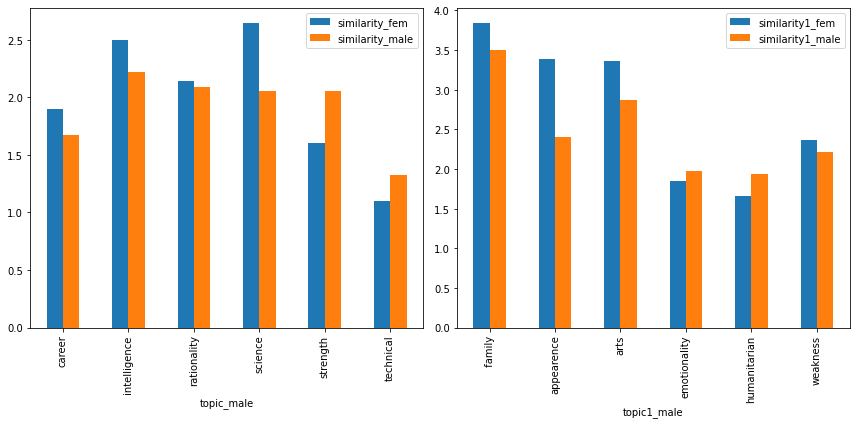

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))  # 1 row, 2 columns
both.plot(x="topic_male", y=["similarity_fem", "similarity_male"], kind="bar", ax=ax1)
both.plot(x="topic1_male", y=["similarity1_fem", "similarity1_male"], kind="bar", ax=ax2)

plt.tight_layout()

In [35]:
# Compare words vectors closeness 
                  # Mother     #Father
model.similarity('мама_NOUN', 'папа_NOUN')

0.70124865

In [36]:
# Closest 10 words to all Attributes by coefficient of cosine closeness

attr3 = []
for attr_weat_f in targ_weat_files:
        file_path = "./word_sets/{}".format(attr_weat_f)
        attr_weat = pd.read_csv(file_path)
        attr1, attr2 = list(attr_weat.iloc[:,0]), list(attr_weat.iloc[:,1])
        attr1_name, attr2_name = attr_weat.columns[0], attr_weat.columns[1]
        
        for l in attr1:
            if l not in attr3:
                attr3.append(l)

        for word in attr3:
    # есть ли слово в модели? Может быть, и нет
            if word in model:
                print(word)
        # выдаем 10 ближайших соседей слова:
                for i in model.most_similar(positive=[word], topn=10):
            # слово + коэффициент косинусной близости
                    print(i[0], i[1])
                print('\n')
            else:
        # Увы!
                print(word + ' is not present in the model')

работать_VERB
трудиться_VERB 0.7799837589263916
работаловек_NOUN 0.6672151684761047
поработать_VERB 0.6395736932754517
работа_NOUN 0.6036433577537537
проработать_VERB 0.5966764688491821
трудиваться_VERB 0.5523296594619751
заниматься_VERB 0.5392969250679016
вкалывать_VERB 0.5351030826568604
работавать_VERB 0.529278039932251
подрабатывать_VERB 0.5274654626846313


работа_NOUN
работать_VERB 0.6036433577537537
работе_VERB 0.5852137207984924
работе_NOUN 0.5598250031471252
работ_NOUN 0.5483677387237549
работа_PROPN 0.5479819178581238
деятельность_NOUN 0.538638174533844
труд_NOUN 0.5099868774414062
трудемик_NOUN 0.4830320477485657
занятие_NOUN 0.4805604815483093
трудиться_VERB 0.46627500653266907


руководить_VERB
возглавлять_VERB 0.6618939638137817
руководитель_NOUN 0.6346130967140198
руководство_NOUN 0.6168980002403259
курировать_VERB 0.5638869404792786
заведовать_VERB 0.557188868522644
руководящий_VERB 0.5424154996871948
руководить_ADJ 0.5351885557174683
координировать_VERB 0.5315455794334

возглавлять_VERB 0.6618939638137817
руководитель_NOUN 0.6346130967140198
руководство_NOUN 0.6168980002403259
курировать_VERB 0.5638869404792786
заведовать_VERB 0.557188868522644
руководящий_VERB 0.5424154996871948
руководить_ADJ 0.5351885557174683
координировать_VERB 0.5315455794334412
руководить_NOUN 0.5295479893684387
участвовать_VERB 0.5257563591003418


менеджмент_NOUN
менеджмент_PROPN 0.6675181984901428
маркетинг_NOUN 0.6514827013015747
логистика_NOUN 0.5936262607574463
риск-менеджмент_NOUN 0.5771051049232483
контроллинг_NOUN 0.5767196416854858
бухучет_NOUN 0.5531847476959229
инноватика_NOUN 0.549071192741394
аудит_VERB 0.5384727120399475
маркетинг_PROPN 0.5375887155532837
бизнес_NOUN 0.535027265548706


профессионал_NOUN
-профессионал_NOUN 0.6543010473251343
профи_NOUN 0.6288397908210754
профессиональный_ADJ 0.5861596465110779
профессионалка_NOUN 0.5255615711212158
профессионалент_NOUN 0.5245116949081421
-профессионал_VERB 0.5093691349029541
-любитель_NOUN 0.5027585029602051
кикб

генетика_NOUN 0.729245662689209
биохимия_NOUN 0.7243037223815918
зоология_NOUN 0.7008504271507263
химия_NOUN 0.6885766983032227
физиология_NOUN 0.6758818626403809
физика_NOUN 0.669662356376648
естествознание_NOUN 0.6511626839637756
эмбриология_NOUN 0.6432027816772461
иммунология_NOUN 0.642910897731781
гидробиология_NOUN 0.6426892280578613


информатика_NOUN
кибернетика_NOUN 0.6780419945716858
информатика_PROPN 0.6737520098686218
математика_NOUN 0.6484509706497192
биоинформатика_NOUN 0.5980738997459412
политология_NOUN 0.5951892137527466
радиофизика_NOUN 0.5945334434509277
системотехник_NOUN 0.5901397466659546
информатизация_NOUN 0.5774233341217041
фотоник_NOUN 0.5770266652107239
социология_NOUN 0.5761544704437256


университет_NOUN
университет_PROPN 0.7711982727050781
университете_NOUN 0.6794787645339966
университета_NOUN 0.6617053747177124
университет_VERB 0.6572054624557495
колледж_NOUN 0.6150892972946167
институт_NOUN 0.6068935990333557
университетский_ADJ 0.6058740615844727
гарвард

работать_VERB 0.6036433577537537
работе_VERB 0.5852137207984924
работе_NOUN 0.5598250031471252
работ_NOUN 0.5483677387237549
работа_PROPN 0.5479819178581238
деятельность_NOUN 0.538638174533844
труд_NOUN 0.5099868774414062
трудемик_NOUN 0.4830320477485657
занятие_NOUN 0.4805604815483093
трудиться_VERB 0.46627500653266907


руководить_VERB
возглавлять_VERB 0.6618939638137817
руководитель_NOUN 0.6346130967140198
руководство_NOUN 0.6168980002403259
курировать_VERB 0.5638869404792786
заведовать_VERB 0.557188868522644
руководящий_VERB 0.5424154996871948
руководить_ADJ 0.5351885557174683
координировать_VERB 0.5315455794334412
руководить_NOUN 0.5295479893684387
участвовать_VERB 0.5257563591003418


менеджмент_NOUN
менеджмент_PROPN 0.6675181984901428
маркетинг_NOUN 0.6514827013015747
логистика_NOUN 0.5936262607574463
риск-менеджмент_NOUN 0.5771051049232483
контроллинг_NOUN 0.5767196416854858
бухучет_NOUN 0.5531847476959229
инноватика_NOUN 0.549071192741394
аудит_VERB 0.5384727120399475
маркетин

неглупый_ADJ 0.7204810380935669
преумный_ADJ 0.6853625178337097
хитрый_ADJ 0.6530604958534241
проницательный_ADJ 0.6508001089096069
рассудительный_ADJ 0.6330661773681641
коммуникабельный_ADJ 0.6316561102867126
начитывать_ADJ 0.6314024329185486
начитанный_ADJ 0.6306951642036438
мудрый_ADJ 0.6306552886962891
дельный_ADJ 0.6270889043807983


логичный_ADJ
логичный_ADV 0.6374428868293762
логически_ADV 0.5761986970901489
закономерный_ADJ 0.5669273138046265
правдоподобный_ADJ 0.5601747632026672
однозначный_ADJ 0.5571218729019165
обоснованный_ADJ 0.556781530380249
нелогичный_ADJ 0.5550544261932373
понятный_ADJ 0.553281307220459
очевидный_ADJ 0.5521669983863831
логично_ADV 0.5497422814369202


вдумчивый_ADJ
внимательный_ADJ 0.7203547358512878
проницательный_ADJ 0.5936159491539001
чуткий_ADJ 0.5897228121757507
непредвзятый_ADJ 0.5882909297943115
терпеливый_ADJ 0.5770238637924194
раздумчивый_ADJ 0.5716696381568909
старательный_ADJ 0.5621508359909058
пытливый_ADJ 0.5566064715385437
знающий_ADJ 0.5

алгебра_NOUN 0.6894025206565857
математика_NOUN 0.6646339297294617
планиметрия_NOUN 0.645863950252533
начертательный_ADJ 0.6448103189468384
алгебраический_ADJ 0.6346616744995117
псевдориманова_NOUN 0.6340433359146118
тригонометрия_NOUN 0.6245520114898682
стереометрия_NOUN 0.5989583730697632
арифметика_NOUN 0.5931870937347412
римановый_ADJ 0.5915492177009583


вычисление_NOUN
вычисление_PROPN 0.6517271399497986
распараллеливание_NOUN 0.6258237957954407
факторизация_NOUN 0.6258218288421631
перемножение_NOUN 0.6199082136154175
вычислять_VERB 0.618014395236969
интегрирование_NOUN 0.6167222261428833
целочислять_ADJ 0.6158465147018433
факториать_NOUN 0.6041260361671448
аксиоматизация_NOUN 0.6001941561698914
линеаризация_NOUN 0.5982326865196228


уравнение_NOUN
уравнение_PROPN 0.7445282340049744
навье-стокс_PROPN 0.7065654993057251
интегро-дифференциальный_ADJ 0.7024822235107422
производная_NOUN 0.6709126234054565
гамильтониан_NOUN 0.6637020707130432
неголономный_ADJ 0.6602633595466614
лагран

воспитанный_VERB 0.779067873954773
воспитать_ADJ 0.6420015692710876
воспитать_VERB 0.6155657768249512
воспитывать_VERB 0.5964524149894714
благовоспитать_ADJ 0.5896368026733398
благовоспитанный_ADJ 0.5828376412391663
воспитанный_NOUN 0.5638155341148376
уживчивый_ADJ 0.5635891556739807
интеллигентный_ADJ 0.5522337555885315
начитанный_ADJ 0.5248077511787415


эрудированный_ADJ
эрудированный_VERB 0.6512224078178406
талантливый_ADJ 0.6389450430870056
высокообразованный_ADJ 0.6208879947662354
начитывать_ADJ 0.5943908095359802
начитанный_ADJ 0.5884059071540833
умный_ADJ 0.5821413993835449
проницательный_ADJ 0.5793665647506714
начитанный_VERB 0.5790067911148071
разносторонне_ADV 0.5774879455566406
разносторонний_ADJ 0.5717877745628357


заумный_ADJ
абстрактный_ADJ 0.5108932852745056
заумь_NOUN 0.5073592662811279
афористичный_ADJ 0.5039408802986145
остранение_NOUN 0.49782437086105347
наукообразный_ADJ 0.48818278312683105
троп_NOUN 0.4840575158596039
маловразумительный_ADJ 0.4840323328971863
выс

астрофизика_NOUN 0.6866933107376099
астрометрия_NOUN 0.6734320521354675
математика_NOUN 0.6726306080818176
радиоастрономия_NOUN 0.6539723873138428
физика_NOUN 0.6515183448791504
метеорология_NOUN 0.6486696600914001
космология_NOUN 0.6147345304489136
астрология_NOUN 0.5997555255889893
астрономия_PROPN 0.5956294536590576
планетология_NOUN 0.5928137302398682


исследование_NOUN
изучение_NOUN 0.7652465105056763
исследование_PROPN 0.7315333485603333
изыскание_NOUN 0.7143746614456177
анализ_NOUN 0.7105922102928162
обследование_NOUN 0.6128227114677429
эксперимент_NOUN 0.6127878427505493
метаанализ_NOUN 0.5968142151832581
исследовать_VERB 0.5961412787437439
изучений_NOUN 0.59210604429245
изучение_PROPN 0.5895407795906067


математика_NOUN
физика_NOUN 0.7486538290977478
астрономия_NOUN 0.6726306080818176
математик_NOUN 0.6653538942337036
геометрия_NOUN 0.6646338105201721
химия_NOUN 0.6629785299301147
информатика_NOUN 0.6484512090682983
алгебра_NOUN 0.6394898891448975
математический_ADJ 0.637853

победитель_PROPN 0.708003580570221
финалист_NOUN 0.6709765195846558
победительница_NOUN 0.6654518842697144
победитель_VERB 0.5847474336624146
-победитель_NOUN 0.5768040418624878
триумфатор_NOUN 0.5536311864852905
финалиста_NOUN 0.5333527326583862
призер_NOUN 0.528546929359436
побеждать_VERB 0.5276551842689514
полуфиналист_NOUN 0.514731764793396


высокомерие_NOUN
самоуверенность_NOUN 0.6852174401283264
надменность_NOUN 0.6794593334197998
цинизм_NOUN 0.6636955142021179
презрение_NOUN 0.6594168543815613
заносчивость_NOUN 0.6524320840835571
равнодушие_NOUN 0.6488499045372009
высокомерный_ADJ 0.6314759254455566
подозрительность_NOUN 0.6273852586746216
пренебрежение_NOUN 0.6265133023262024
легкомыслие_NOUN 0.618762731552124


электротехника_NOUN
радиотехника_NOUN 0.7043251395225525
электротехник_NOUN 0.6762951612472534
электротехнический_ADJ 0.6304875612258911
электрофизика_NOUN 0.6057294607162476
теплотехник_NOUN 0.6029260754585266
оптоэлектроник_NOUN 0.5956867933273315
электроника_NOUN 0.

знание_NOUN 0.7973768711090088
познавание_NOUN 0.6988855600357056
постижение_NOUN 0.6838840842247009
познаваемый_VERB 0.6402060985565186
понимание_NOUN 0.6203131079673767
бытие_NOUN 0.6179012656211853
гносеология_NOUN 0.6138022541999817
сверхчувстветь_ADJ 0.6135546565055847
познавать_VERB 0.6132564544677734
мышление_NOUN 0.6118555068969727


рассудительность_NOUN
добросердечие_NOUN 0.5992723703384399
благоразумие_NOUN 0.5947302579879761
сообразительность_NOUN 0.5901687741279602
решительность_NOUN 0.5721946358680725
хладнокровие_NOUN 0.5640964508056641
проницательность_NOUN 0.5592486262321472
кротость_NOUN 0.5536706447601318
честность_NOUN 0.5518651604652405
умеренность_NOUN 0.548480749130249
сметливость_NOUN 0.5476976037025452


опыт_NOUN
опытомя_NOUN 0.6849164366722107
опыт_PROPN 0.651919960975647
практика_NOUN 0.6003483533859253
эксперимент_NOUN 0.5636329650878906
накапливать_VERB 0.5273318290710449
наблюдение_NOUN 0.5124012231826782
знание_NOUN 0.5090479850769043
навык_NOUN 0.508865

## Plotting the PCA analysis for Male and Female terms & Topic attributes

In [98]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels_f = []
    tokens_f = []

    for w in female_terms:
        if w in model:
            tokens_f.append(model[w])
            labels_f.append(w)
            
            
    labels_m = []
    tokens_m = []

    for w in male_terms:
        if w in model:
            tokens_m.append(model[w])
            labels_m.append(w)  
            
            
            
    labels_all = []
    tokens_all = []

    for w in only_terms:
        if w in model:
            tokens_all.append(model[w])
            labels_all.append(w)  
            
    
    tsne_model = TSNE(perplexity=3, n_components=3, init='pca', n_iter=1500, random_state=3)
    
    new_values_f = tsne_model.fit_transform(tokens_f)
    x_f = []
    y_f = []
    for value in new_values_f:
        x_f.append(value[0])
        y_f.append(value[1])
        
        
    new_values_m = tsne_model.fit_transform(tokens_m)
    x_m = []
    y_m = []
    for value in new_values_m:
        x_m.append(value[0])
        y_m.append(value[1])  
        
        
    new_values_all = tsne_model.fit_transform(tokens_all)
    x_all = []
    y_all = []
    for value in new_values_all:
        x_all.append(value[0])
        y_all.append(value[1])      
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x_f)):
        plt.scatter(x_f[i],y_f[i], color='red')
        plt.annotate(labels_f[i],
                     xy=(x_f[i], y_f[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    for i in range(len(x_m)):
        plt.scatter(x_m[i],y_m[i], color='green')
        plt.annotate(labels_m[i],
                     xy=(x_m[i], y_m[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')  
        
        
    for i in range(len(x_all)):
        plt.scatter(x_all[i],y_all[i], color='pink')
        plt.annotate(labels_all[i],
                     xy=(x_all[i], y_all[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')  
        
    plt.show()

/Users/tatiana/opt/anaconda3/envs/SharedTasksTest/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/tatiana/opt/anaconda3/envs/SharedTasksTest/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/tatiana/opt/anaconda3/envs/SharedTasksTest/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/tatiana/opt/anaconda3/envs/SharedTasksTest/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/U

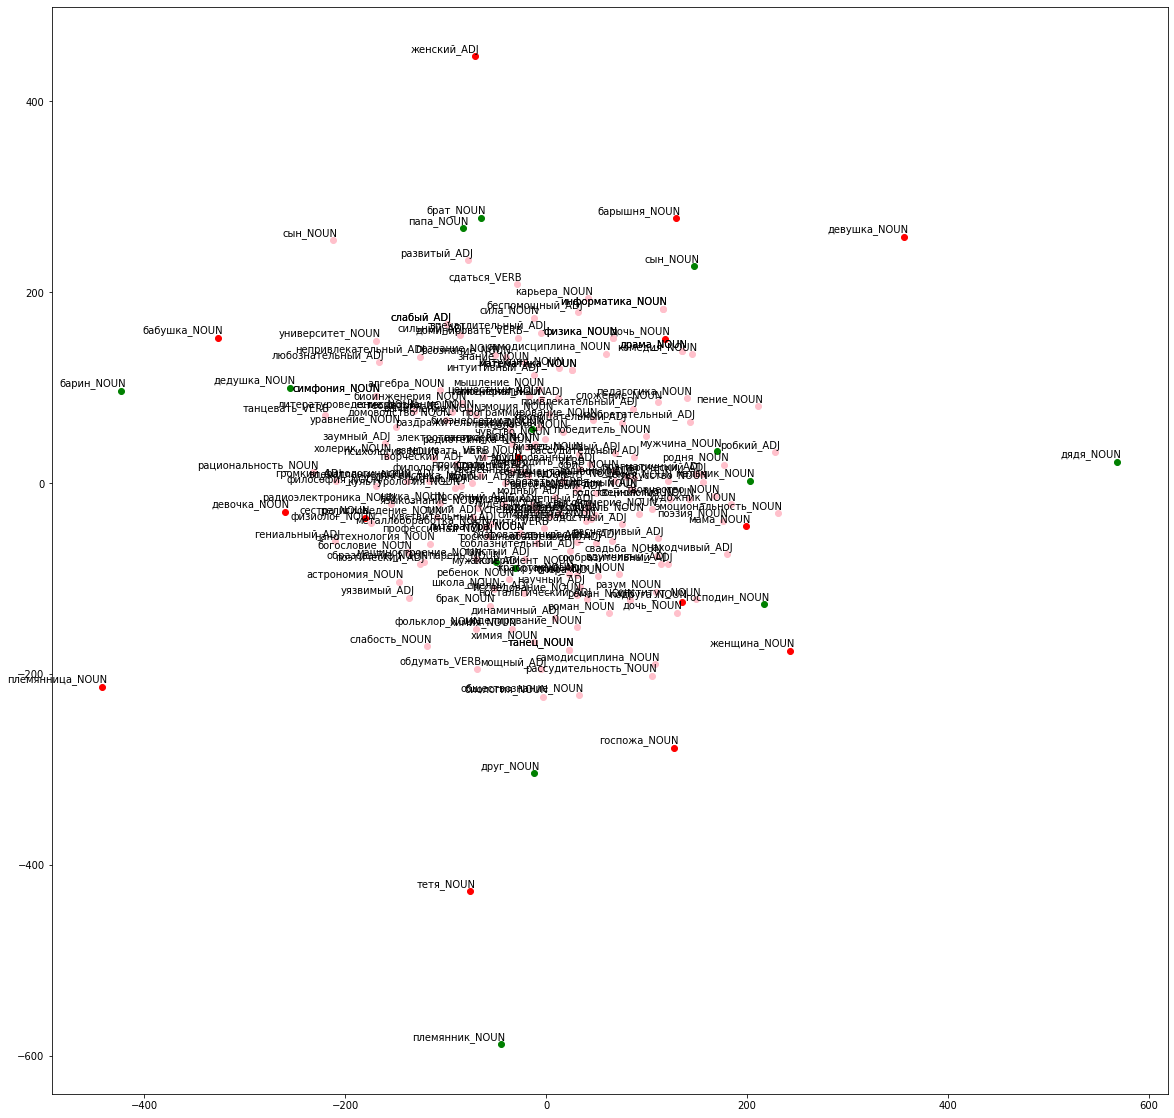

In [99]:
tsne_plot(model)